## Demo LBM CaImAn Pipeline

Processing and exploring the LBM dataset located [here](https://rockefeller-my.sharepoint.com/my?id=%2Fpersonal%2Ffoconnell%5Frockefeller%5Fedu%2FDocuments%2FMBO%2Fdatasets%2Fdemas%5F2023&FolderCTID=0x012000228B6C10491B3546BA7A3CF92268F533I)

In [1]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path
import logging

from copy import deepcopy
from itertools import product

import mesmerize_core as mc
import lbm_caiman_python as lcp
from mesmerize_viz import *
from mesmerize_core.caiman_extensions.cnmf import cnmf_cache
import fastplotlib as fpl
import tifffile

import caiman as cm
from caiman.source_extraction.cnmf import cnmf, params
from caiman.motion_correction import high_pass_filter_space
from caiman.summary_images import correlation_pnr

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ipywidgets import IntSlider, VBox
from sidecar import Sidecar

try:
    import cv2
    cv2.setNumThreads(0)
except():
    pass

if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

pd.options.display.max_colwidth = 120

logger = logging.getLogger("caiman")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
log_format = logging.Formatter("%(relativeCreated)12d [%(filename)s:%(funcName)10s():%(lineno)s] [%(process)d] %(message)s")
handler.setFormatter(log_format)
logger.addHandler(handler)

logging.getLogger("caiman").setLevel(logging.WARNING)

WGPU: enumerate_adapters() is deprecated, use enumerate_adapters_sync() instead.
WGPU: request_adapter() is deprecated, use request_adapter_sync() instead.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA RTX A4000,DiscreteGPU,Vulkan,560.94
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❗ limited,Microsoft Basic Render Driver,CPU,D3D12,
❌,NVIDIA RTX A4000/PCIe/SSE2,Unknown,OpenGL,4.6.0 NVIDIA 560.94


In [2]:
parent_path = Path().home() / "lbm_data" / "demo_data"
batch_path = parent_path / 'batch.pickle'
mc.set_parent_raw_data_path(str(parent_path))

try:
    df = mc.load_batch(batch_path)
except (IsADirectoryError, FileNotFoundError):
    df = mc.create_batch(batch_path)

df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid


In [3]:
data = [x for x in Path(parent_path).glob('*.tif*')][0]
data

WindowsPath('C:/Users/RBO/lbm_data/demo_data/plane_1.tiff')

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
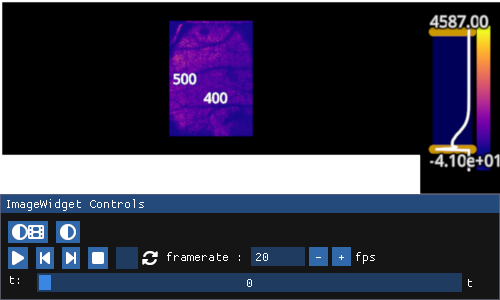

In [8]:
iw = fpl.ImageWidget(tifffile.memmap(data))
iw.show()

In [9]:
iw.close()

In [7]:
metadata = lcp.get_metadata(data)
params = lcp.params_from_metadata(metadata)

2.0
Overlaps too small. Increasing to neuron diameter.


In [8]:
params

{'main': {'pw_rigid': True,
  'max_shifts': [2, 2],
  'strides': [15, 13],
  'overlaps': [2, 2],
  'min_mov': None,
  'gSig_filt': [0, 0],
  'max_deviation_rigid': 3,
  'border_nan': 'copy',
  'splits_els': 14,
  'upsample_factor_grid': 4,
  'use_cuda': False,
  'num_frames_split': 50,
  'niter_rig': 1,
  'is3D': False,
  'splits_rig': 14,
  'num_splits_to_process_rig': None,
  'fr': 4.68692,
  'dxy': [4.17, 5.0],
  'decay_time': 0.4,
  'p': 2,
  'nb': 1,
  'K': 20,
  'rf': 64,
  'stride': [8, 8],
  'gSig': 2.0,
  'gSiz': (5.0, 5.0),
  'method_init': 'greedy_roi',
  'rolling_sum': True,
  'use_cnn': False,
  'ssub': 1,
  'tsub': 1,
  'merge_thr': 0.7,
  'bas_nonneg': True,
  'min_SNR': 1.4,
  'rval_thr': 0.8}}

In [9]:
df.caiman.add_item(algo='mcorr', input_movie_path=data, params=params, item_name='mcorr')

In [10]:
df.iloc[-1].caiman.run()

Running 2abb5a76-9bba-46a0-945e-d20239c4a8b9 with local backend
starting mc


       81819 [cluster.py:setup_cluster():225] [18056] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
       81893 [params.py:change_params():1151] [18056] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


In [15]:
df = df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'pw_rigid': True, 'max_shifts': [2, 2], 'strides': [15, 13], 'overlaps': [2, 2], 'min_mov': None, 'gSig_fi...",{'mean-projection-path': '2abb5a76-9bba-46a0-945e-d20239c4a8b9/2abb5a76-9bba-46a0-945e-d20239c4a8b9_mean_projection....,2025-01-13T12:40:35,2025-01-13T12:57:38,1021.8 sec,None,2abb5a76-9bba-46a0-945e-d20239c4a8b9


In [ ]:
metrics_files = lcp.compute_mcorr_metrics_batch(df)

In [ ]:
metrics_df = lcp._create_df_from_metric_files(metrics_files)
metrics_df

In [ ]:
lcp.remove_batch_duplicates(df)

In [48]:
params['main']['K'] = 30

In [16]:
df.caiman.add_item(algo='cnmf', input_movie_path=df.iloc[-1], params=params, item_name='cnmf')

In [17]:
df.iloc[-1].caiman.run()

Running ae777e1e-ac43-4a74-9987-22732df89c2a with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                              cnmf
input_movie_path    2abb5a76-9bba-46a0-945e-d20239c4a8b9\2abb5a76-9bba-46a0-945e-d20239c4a8b9-plane_1_els__d1_1000_d2_720_d3_1_order_F_f...
params              {'main': {'pw_rigid': True, 'max_shifts': [2, 2], 'strides': [15, 13], 'overlaps': [2, 2], 'min_mov': None, 'gSig_fi...
outputs                                                                                                                                None
added_time                                                                                                              2025-01-13T13:15:01
ra

     2148073 [cluster.py:setup_cluster():225] [18056] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
     2148144 [params.py:change_params():1151] [18056] In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


making memmap


     2289103 [cluster.py:setup_cluster():225] [18056] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
performing eval


In [18]:
df = df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_1.tiff,"{'main': {'pw_rigid': True, 'max_shifts': [2, 2], 'strides': [15, 13], 'overlaps': [2, 2], 'min_mov': None, 'gSig_fi...",{'mean-projection-path': '2abb5a76-9bba-46a0-945e-d20239c4a8b9/2abb5a76-9bba-46a0-945e-d20239c4a8b9_mean_projection....,2025-01-13T12:40:35,2025-01-13T12:57:38,1021.8 sec,None,2abb5a76-9bba-46a0-945e-d20239c4a8b9
1,cnmf,cnmf,2abb5a76-9bba-46a0-945e-d20239c4a8b9\2abb5a76-9bba-46a0-945e-d20239c4a8b9-plane_1_els__d1_1000_d2_720_d3_1_order_F_f...,"{'main': {'pw_rigid': True, 'max_shifts': [2, 2], 'strides': [15, 13], 'overlaps': [2, 2], 'min_mov': None, 'gSig_fi...",{'mean-projection-path': 'ae777e1e-ac43-4a74-9987-22732df89c2a/ae777e1e-ac43-4a74-9987-22732df89c2a_mean_projection....,2025-01-13T13:15:01,2025-01-13T13:24:15,551.85 sec,None,ae777e1e-ac43-4a74-9987-22732df89c2a


In [19]:
import fastplotlib as fpl

In [20]:
from caiman.utils.visualization import view_quilt
cnmf_model = df.iloc[-1].cnmf.get_output()
cnmf_patch_width = cnmf_model.params.patch['rf']*2 + 1
cnmf_patch_overlap = cnmf_model.params.patch['stride'] + 1
cnmf_patch_stride = cnmf_patch_width - cnmf_patch_overlap
print(f'Patch width: {cnmf_patch_width} , Stride: {cnmf_patch_stride}, Overlap: {cnmf_patch_overlap}');

Patch width: 129 , Stride: [120 120], Overlap: [9 9]


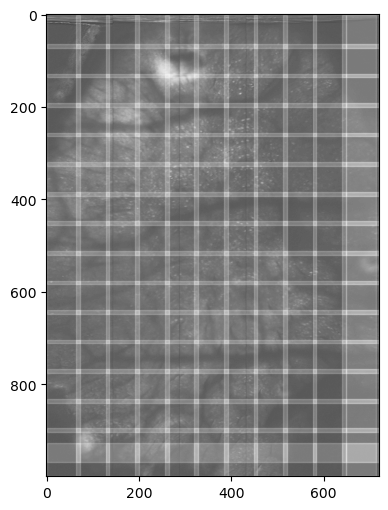

In [22]:
# plot the patches
corr = df.iloc[-1].caiman.get_corr_image()
patch_ax = view_quilt(corr,  cnmf_model.params.patch['rf'],  cnmf_model.params.patch['stride'][0]);

In [23]:
contours = df.iloc[-1].cnmf.get_contours("good", swap_dim=False)
filtered = [a for a in contours[0] if a.size > 1]

RFBOutputContext()

JupyterRenderCanvas(css_height='560.0px', css_width='700.0px')
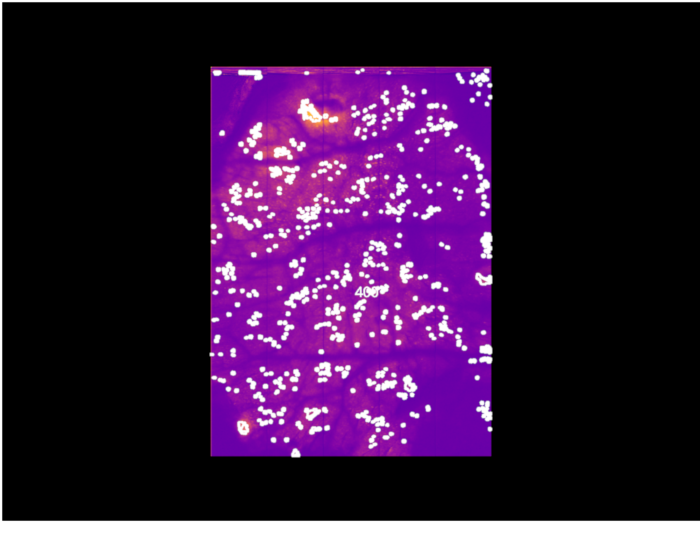

In [24]:
figure = fpl.Figure(size=(700, 560))
image_graphic = figure[0, 0].add_image(data=corr)
graphic = figure[0, 0].add_line_collection(
    filtered,
    name="contours"
)
figure.show()

In [91]:
figure.close()